# Alzheimer's Prediction using MMSE Features

In [34]:
# Core Libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Logistic Regression tools
from Logistic_bootstrap_metrics import bootstrap_metrics, plot_roc_curve, build_summary_table

# Machine Learning Tools
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    accuracy_score,
    f1_score,
    recall_score,
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
)

# Other Models (for later if you use them)
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns

# Resampling
from imblearn.over_sampling import SMOTE


## Load and Prepare Data

In [35]:
# Load dataset
df = pd.read_csv("data/Filtered_Data.csv")

# Split into train and test based on 'Split' column
df_train = df[df['Split'] == 'Train']
df_test = df[df['Split'] == 'Test']

# Define MMSE question columns
mmse_cols = [
    "MMYEAR", "MMMONTH", "MMDAY", "MMSEASON", "MMDATE",
    "MMSTATE", "MMCITY", "MMAREA", "MMHOSPIT", "MMFLOOR",

    "WORD1", "WORD2", "WORD3",

    "MMD", "MML", "MMR", "MMO", "MMW",

    "WORD1DL", "WORD2DL", "WORD3DL",

    "MMWATCH", "MMPENCIL", "MMREPEAT",
    "MMHAND", "MMFOLD", "MMONFLR",
    "MMREAD", "MMWRITE", "MMDRAW"
]

# Define MMSE question categories
categories = {
    "Orientation_Time": ["MMYEAR", "MMMONTH", "MMDAY", "MMSEASON", "MMDATE"],
    "Orientation_Place": ["MMSTATE", "MMCITY", "MMAREA", "MMHOSPIT", "MMFLOOR"],
    "Registration": ["WORD1", "WORD2", "WORD3"],
    "Attention_Calculation": ["MMD", "MML", "MMR", "MMO", "MMW"],
    "Recall": ["WORD1DL", "WORD2DL", "WORD3DL"],
    "Language": ["MMWATCH", "MMPENCIL", "MMREPEAT", "MMHAND", "MMFOLD", "MMONFLR", "MMREAD", "MMWRITE", "MMDRAW"]
}

# Significant categories
significant_categories = {
    "Orientation_Time": ["MMYEAR", "MMMONTH", "MMDAY", "MMSEASON", "MMDATE"],
    "Orientation_Place": ["MMSTATE", "MMCITY", "MMAREA", "MMHOSPIT", "MMFLOOR"],
    "Attention_Calculation": ["MMD", "MML", "MMR", "MMO", "MMW"],
    "Recall": ["WORD1DL", "WORD2DL", "WORD3DL"],
    "Language": ["MMWATCH", "MMPENCIL", "MMREPEAT", "MMHAND", "MMFOLD", "MMONFLR", "MMREAD", "MMWRITE", "MMDRAW"]
}

# Updated siginificant categories (With good questions)
updated_categories = {
    "Orientation_Time": ["MMYEAR", "MMMONTH", "MMDAY", "MMSEASON", "MMDATE"],
    "Orientation_Place": ["MMSTATE", "MMCITY", "MMAREA", "MMHOSPIT", "MMFLOOR"],
    "Attention_Calculation": ["MMD", "MML", "MMR", "MMO", "MMW"],
    "Recall": ["WORD1DL", "WORD2DL", "WORD3DL"],
    "Language": ["MMWATCH", "MMPENCIL"]
}

# BioBERT embeddings
df_numerical_biobert_train = pd.read_csv("data/Embeddings/Numerical_BioBERT_Train.csv")
df_numerical_biobert_test = pd.read_csv("data/Embeddings/Numerical_BioBERT_Test.csv")
df_biobert_train = pd.read_csv("data/Embeddings/BioBERT_Train.csv")
df_biobert_test = pd.read_csv("data/Embeddings/BioBERT_Test.csv")
df_context_biobert_test = pd.read_csv("data/Embeddings/Context_BioBERT_Train.csv")
df_context_biobert_train = pd.read_csv("data/Embeddings/Context_BioBERT_Test.csv")

# ClinicalBERT embeddings
df_numerical_clinicalbert_train = pd.read_csv("data/Embeddings/Numerical_ClinicalBERT_Train.csv")
df_numerical_clinicalbert_test = pd.read_csv("data/Embeddings/Numerical_ClinicalBERT_Test.csv")
df_clincalbert_train = pd.read_csv("data/Embeddings/ClinicalBERT_Train.csv")
df_clincalbert_test = pd.read_csv("data/Embeddings/ClinicalBERT_Test.csv")
df_context_clinicalbert_test = pd.read_csv("data/Embeddings/Context_ClinicalBERT_Train.csv")
df_context_clinicalbert_train = pd.read_csv("data/Embeddings/Context_ClinicalBERT_Test.csv")

# MedBERT embeddings
df_numerical_medbert_train = pd.read_csv("data/Embeddings/Numerical_MedBERT_Train.csv")
df_numerical_medbert_test = pd.read_csv("data/Embeddings/Numerical_MedBERT_Test.csv")
df_medbert_train = pd.read_csv("data/Embeddings/MedBERT_Train.csv")
df_medbert_test = pd.read_csv("data/Embeddings/MedBERT_Test.csv")
df_context_medbert_test = pd.read_csv("data/Embeddings/Context_MedBERT_Train.csv")
df_context_medbert_train = pd.read_csv("data/Embeddings/Context_MedBERT_Test.csv")


## Helper Functions

In [36]:
def prepare_features_for_logistic_regression(X_train, X_test, variance_threshold=1e-5, correlation_threshold=0.98):
    
    # Step 1: Remove constant (zero variance) features
    selector = VarianceThreshold(threshold=variance_threshold)
    X_train_reduced = selector.fit_transform(X_train)
    X_test_reduced = selector.transform(X_test)

    kept_features = X_train.columns[selector.get_support()]
    X_train_reduced = pd.DataFrame(X_train_reduced, columns=kept_features, index=X_train.index)
    X_test_reduced = pd.DataFrame(X_test_reduced, columns=kept_features, index=X_test.index)

    # Step 2: Remove highly correlated features
    corr_matrix = X_train_reduced.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]

    X_train_final = X_train_reduced.drop(columns=to_drop, errors='ignore')
    X_test_final = X_test_reduced.drop(columns=to_drop, errors='ignore')

    return X_train_final, X_test_final

def run_logistic_regression_pipeline(train_df, test_df, embedding_cols, categories, model_name="ClinicalBERT", target_var='AD', n_bootstrap=1000):

    # # --- Per category logistic regression ---
    # category_results = []
    # for category_name, mmse_codes in categories.items():
    #     print(f"\nRunning logistic regression for {model_name} - Category: {category_name}")

    #     train_filtered = train_df[train_df['MMSE Code'].isin(mmse_codes)]
    #     test_filtered = test_df[test_df['MMSE Code'].isin(mmse_codes)]

    #     if len(train_filtered) < 10 or len(test_filtered) < 10:
    #         print(f"Skipping {category_name} (not enough samples)")
    #         continue

    #     X_train = train_filtered[embedding_cols]
    #     y_train = train_filtered[target_var]
    #     X_test = test_filtered[embedding_cols]
    #     y_test = test_filtered[target_var]

    #     result = bootstrap_metrics(
    #         df_train=X_train,
    #         df_test=X_test,
    #         independent_vars=embedding_cols,
    #         dep_var_train=y_train,
    #         dep_var_test=y_test,
    #         n_bootstrap=n_bootstrap
    #     )

    #     category_results.append({
    #         'Category': category_name,
    #         'Best Threshold': result["Best Threshold"],
    #         'Odds Ratios': result["Odds Ratios (one-time fit)"],
    #         'Bootstrapped Metrics': result["Bootstrapped Metrics"],
    #         'True Labels': result["True Labels"],
    #         'Predicted Probabilities': result["Predicted Probabilities"]
    #     })

    # --- Combined model: mean embeddings per category ---
    print(f"\nRunning combined logistic regression for {model_name} (mean embeddings per category)")

    def compute_category_means(df, embedding_cols, mmse_codes_dict):
        category_mean_features = pd.DataFrame(index=df['subject_id'].unique())
        for category, codes in mmse_codes_dict.items():
            filtered = df[df['MMSE Code'].isin(codes)]
            if not filtered.empty:
                mean_embeddings = filtered.groupby('subject_id')[embedding_cols].mean()
                mean_embeddings = mean_embeddings.add_prefix(f"{category}_")
                category_mean_features = category_mean_features.join(mean_embeddings, how='left')
        return category_mean_features

    train_df['subject_id'] = train_df['subject_id'].astype(str)
    test_df['subject_id'] = test_df['subject_id'].astype(str)

    train_means = compute_category_means(train_df, embedding_cols, categories)
    test_means = compute_category_means(test_df, embedding_cols, categories)

    train_labels = train_df[['subject_id', target_var]].drop_duplicates().set_index('subject_id')
    test_labels = test_df[['subject_id', target_var]].drop_duplicates().set_index('subject_id')

    train_means = train_means.join(train_labels).dropna()
    test_means = test_means.join(test_labels).dropna()

    X_train_combined = train_means.drop(columns=[target_var])
    y_train_combined = train_means[target_var]
    X_test_combined = test_means.drop(columns=[target_var])
    y_test_combined = test_means[target_var]

    X_train_final, X_test_final = prepare_features_for_logistic_regression(X_train_combined, X_test_combined)

    combined_result = bootstrap_metrics(
        df_train=X_train_final,
        df_test=X_test_final,
        independent_vars=X_train_final.columns.tolist(),
        dep_var_train=y_train_combined,
        dep_var_test=y_test_combined,
        n_bootstrap=n_bootstrap
    )

    # # Printing results for each category
    # for result in category_results:
    #     print(f"\n=== Results for {model_name} - Category: {result['Category']} ===")
    #     print("\n----- Odds Ratios (one-time fit) -----")
    #     print(result["Odds Ratios"])
    #     print(f"\nBest Threshold Automatically Found: {result['Best Threshold']:.2f}")
    #     print("\n----- Bootstrapped Metrics (1000 runs) -----")
    #     for metric, (mean, ci) in result["Bootstrapped Metrics"].items():
    #         print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")
    
    # --- Final prints ---
    print(f"\n=== Combined Results for {model_name} ===")
    print("\n----- Odds Ratios (one-time fit) -----")
    print(combined_result["Odds Ratios (one-time fit)"])
    print(f"\nBest Threshold Automatically Found: {combined_result['Best Threshold']:.2f}")
    print("\n----- Bootstrapped Metrics (1000 runs) -----")
    for metric, (mean, ci) in combined_result["Bootstrapped Metrics"].items():
        print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

    plot_roc_curve(combined_result["True Labels"], combined_result["Predicted Probabilities"], title=f"ROC Curve - {model_name} Combined")

    return combined_result

def drop_highly_correlated_features(df, threshold=0.90):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features to drop
    to_drop = []
    for column in upper.columns:
        if any(upper[column] > threshold):
            correlated_features = upper.index[upper[column] > threshold].tolist()
            to_drop.append(column)
            
    # Drop duplicated entries
    to_drop = list(set(to_drop))
    return to_drop

def select_good_questions(results, auc_threshold=0.55, pval_threshold=0.05):
    good_questions = []
    bad_questions = []

    for res in results:
        try:
            auc_mean = res['Bootstrapped Metrics']['AUC'][0]
            p_value = res['Odds Ratios']['p-value'].iloc[1]  # assuming feature is second row

            if (auc_mean >= auc_threshold) and (p_value <= pval_threshold):
                good_questions.append(res['Question'])
            else:
                bad_questions.append(res['Question'])
        except Exception as e:
            print(f"Error processing {res['Question']}: {e}")
            bad_questions.append(res['Question'])

    return good_questions, bad_questions

def update_categories_with_good_questions(categories, good_questions):
    updated_categories = {}

    for cat_name, questions in categories.items():
        filtered_questions = [q for q in questions if q in good_questions]
        if filtered_questions:
            updated_categories[cat_name] = filtered_questions

    return updated_categories


## Logistic Regression on MMSCORE with Bootstrapping

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Best Threshold found automatically: 0.12

===== Odds Ratios (one-time fit) — MMSE Score =====
           Odds Ratio   95% CI Lower  95% CI Upper       p-value
const    1.108315e+07  584766.636652  2.100603e+08  3.205904e-27
MMSCORE  5.208992e-01       0.467053  5.809535e-01  1.066395e-31

Best Threshold Automatically Found: 0.12

===== Bootstrapped Metrics (1000 runs) - MMSE Score =====
AUC: Mean = 0.7946, 95% CI = [0.7893, 0.8066]
Balanced Accuracy: Mean = 0.7253, 95% CI = [0.7208, 0.7335]
Sensitivity: Mean = 0.6783, 95% CI = [0.6727, 0.6909]
Specificity: Mean = 0.7723, 95% CI = [0.7690, 0.7798]
Precision: Mean = 0.3716, 95% CI = [0.3663, 0.3800]
F1-score: Mean = 0.4802, 95% CI = [0.4744, 0.4903]


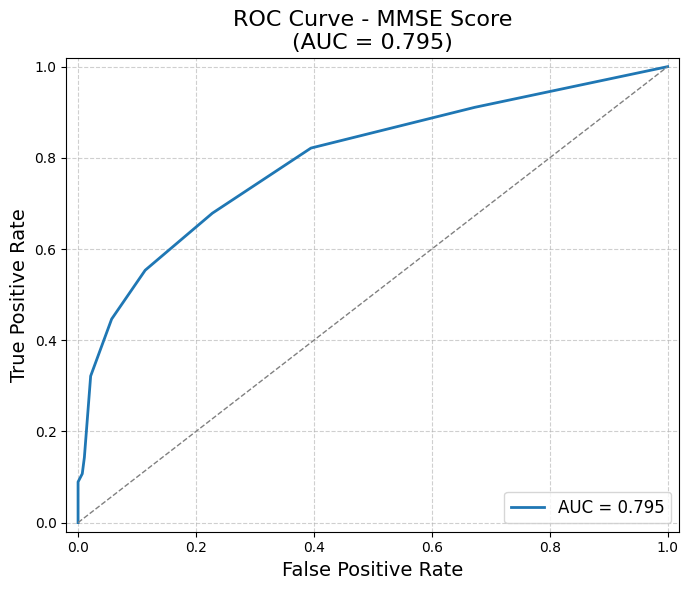

In [37]:
# Define features and target
X_train = df_train[['MMSCORE']]
y_train = df_train['AD']
X_test = df_test[['MMSCORE']]
y_test = df_test['AD']

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
sample_weights = y_train.map(dict(zip(np.unique(y_train), class_weights)))

# Run bootstrapped logistic regression
mmsescore_results = bootstrap_metrics(
    df_train=X_train,
    df_test=X_test,
    independent_vars=['MMSCORE'],
    dep_var_train=y_train,
    dep_var_test=y_test,
    n_bootstrap=1000,
    sample_weights=sample_weights  # Pass class weights
)

# Display results
print("\n===== Odds Ratios (one-time fit) — MMSE Score =====")
print(mmsescore_results["Odds Ratios (one-time fit)"])

print(f"\nBest Threshold Automatically Found: {mmsescore_results['Best Threshold']:.2f}")

print("\n===== Bootstrapped Metrics (1000 runs) - MMSE Score =====")
for metric, (mean, ci) in mmsescore_results["Bootstrapped Metrics"].items():
    print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# (Optional) Plot ROC Curve
plot_roc_curve(mmsescore_results["True Labels"], mmsescore_results["Predicted Probabilities"], title="ROC Curve - MMSE Score")


## Logistic Regression on MMSE Questions with Bootstrapping

In [38]:
# Logistic Regression on MMSE Questions with Bootstrapping and Best Threshold Search

question_results = []
skipped_questions = []

for question in mmse_cols:
    try:
        # Define features and target
        X_train_question = df_train[[question]]
        y_train_question = df_train['AD']
        X_test_question = df_test[[question]]
        y_test_question = df_test['AD']

        # Run logistic regression with bootstrapping
        results_question = bootstrap_metrics(
            df_train=X_train_question,
            df_test=X_test_question,
            independent_vars=[question],
            dep_var_train=y_train_question,
            dep_var_test=y_test_question,
            n_bootstrap=1000
        )

        # Store results
        question_results.append({
            'Question': question,
            'Best Threshold': results_question['Best Threshold'],
            'Odds Ratios': results_question["Odds Ratios (one-time fit)"],
            'Bootstrapped Metrics': results_question["Bootstrapped Metrics"],
            'True Labels': results_question["True Labels"],
            'Predicted Probabilities': results_question["Predicted Probabilities"]
        })

    except Exception as e:
        print(f"Error running logistic regression for question {question}: {e}")
        skipped_questions.append({'Question': question, 'Error': str(e)})

# Display results for each question
for result in question_results:
    print(f"\n===== Odds Ratios (one-time fit) — {result['Question']} =====")
    print(result['Odds Ratios'])

    print(f"\nBest Threshold Automatically Found: {result['Best Threshold']:.2f}")

    print(f"\n===== Bootstrapped Metrics (1000 runs) - {result['Question']} =====")
    for metric, (mean, ci) in result['Bootstrapped Metrics'].items():
        print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# Log skipped questions
if skipped_questions:
    print("\n===== Skipped Questions =====")
    for skipped in skipped_questions:
        print(f"Question: {skipped['Question']}, Error: {skipped['Error']}")

# # (Optional) Plot ROC Curve for each question
# for result in question_results:
#     plot_roc_curve(result["True Labels"], result["Predicted Probabilities"], title=f"ROC Curve - {result['Question']}")

# Select good questions based on AUC and p-value thresholds
good_questions, bad_questions = select_good_questions(question_results, auc_threshold=0.55, pval_threshold=0.05)
print("\n===== Good Questions =====")
for q in good_questions:
    print(q)

print("\n===== Bad Questions =====")
for q in bad_questions:
    print(q)

# Update categories with good questions
updated_categories_questions = update_categories_with_good_questions(categories, good_questions)
print("\n===== Updated Categories with Good Questions =====")
for cat_name, questions in updated_categories_questions.items():
    print(f"{cat_name}: {questions}")



Using class weighting automatically.
Best Threshold found automatically: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.11


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.14


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Error running logistic regression for question WORD1: Singular matrix
Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret

Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



===== Odds Ratios (one-time fit) — MMYEAR =====
        Odds Ratio  95% CI Lower  95% CI Upper       p-value
const     3.600000      1.336592      9.696303  1.128111e-02
MMYEAR    0.049663      0.018088      0.136354  5.658192e-09

Best Threshold Automatically Found: 0.16

===== Bootstrapped Metrics (1000 runs) - MMYEAR =====
AUC: Mean = 0.5125, 95% CI = [0.5037, 0.5146]
Balanced Accuracy: Mean = 0.5125, 95% CI = [0.5037, 0.5146]
Sensitivity: Mean = 0.0357, 95% CI = [0.0182, 0.0364]
Specificity: Mean = 0.9893, 95% CI = [0.9892, 0.9928]
Precision: Mean = 0.3985, 95% CI = [0.2500, 0.5000]
F1-score: Mean = 0.0655, 95% CI = [0.0339, 0.0678]

===== Odds Ratios (one-time fit) — MMMONTH =====
         Odds Ratio  95% CI Lower  95% CI Upper       p-value
const      3.000000      1.275341      7.056934  1.182792e-02
MMMONTH    0.058257      0.024212      0.140177  2.210977e-10

Best Threshold Automatically Found: 0.15

===== Bootstrapped Metrics (1000 runs) - MMMONTH =====
AUC: Mean = 0.5501, 

## Logistic Regression on MMSE Category with Bootstrapping


Running logistic regression for category: Orientation_Time
Using class weighting automatically.
Best Threshold found automatically: 0.10


/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_16565/4055879049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[f"{category}_COMPOSITE"] = df_train[questions].sum(axis=1, skipna=True)
/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_16565/4055879049.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f"{category}_COMPOSITE"] = df_test[questions].sum(axis=1, skipna=True)
/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_16565/4055879049.py:3: SettingWithCop


Running logistic regression for category: Orientation_Place
Using class weighting automatically.
Best Threshold found automatically: 0.13


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



Running logistic regression for category: Registration
Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)



Running logistic regression for category: Attention_Calculation
Using class weighting automatically.
Best Threshold found automatically: 0.39


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



Running logistic regression for category: Recall
Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



Running logistic regression for category: Language
Using class weighting automatically.
Best Threshold found automatically: 0.13


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



============ Results for Orientation_Time ============
----- Odds Ratios (one-time fit) -----
                            Odds Ratio  95% CI Lower  95% CI Upper  \
const                        99.405512     30.134791    327.908557   
Orientation_Time_COMPOSITE    0.248469      0.190197      0.324594   

                                 p-value  
const                       4.265233e-14  
Orientation_Time_COMPOSITE  1.760204e-24  

Best Threshold Automatically Found: 0.10

----- Bootstrapped Metrics (1000 runs) -----
AUC: Mean = 0.6507, 95% CI = [0.6432, 0.6575]
Balanced Accuracy: Mean = 0.6343, 95% CI = [0.6281, 0.6408]
Sensitivity: Mean = 0.4822, 95% CI = [0.4727, 0.4909]
Specificity: Mean = 0.7865, 95% CI = [0.7834, 0.7942]
Precision: Mean = 0.3096, 95% CI = [0.3023, 0.3176]
F1-score: Mean = 0.3770, 95% CI = [0.3688, 0.3857]

============ Results for Orientation_Place ============
----- Odds Ratios (one-time fit) -----
                             Odds Ratio  95% CI Lower  95% CI Up

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)



============ Combined Results ============
----- Odds Ratios (one-time fit) -----
                                   Odds Ratio  95% CI Lower  95% CI Upper  \
const                            2.729334e-22      0.000000           inf   
Orientation_Time_COMPOSITE       3.431941e-01      0.253865      0.463956   
Orientation_Place_COMPOSITE      4.629046e-01      0.294162      0.728444   
Registration_COMPOSITE           1.475229e+09      0.000000           inf   
Attention_Calculation_COMPOSITE  6.587537e-01      0.488677      0.888023   
Recall_COMPOSITE                 5.176974e-01      0.424054      0.632020   
Language_COMPOSITE               6.543024e-01      0.451229      0.948769   

                                      p-value  
const                            9.989788e-01  
Orientation_Time_COMPOSITE       3.591096e-12  
Orientation_Place_COMPOSITE      8.695491e-04  
Registration_COMPOSITE           9.986974e-01  
Attention_Calculation_COMPOSITE  6.156076e-03  
Recall_COMPO

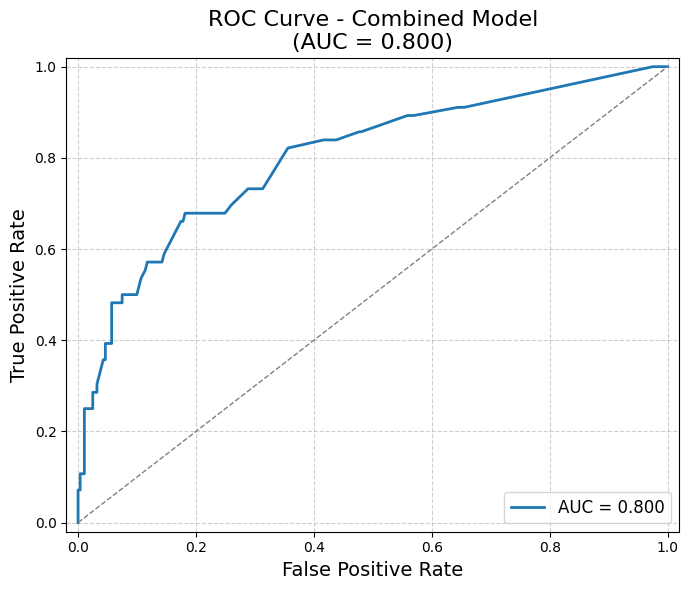


✅ Significant categories selected:
 - Orientation_Time_COMPOSITE
 - Orientation_Place_COMPOSITE
 - Attention_Calculation_COMPOSITE
 - Recall_COMPOSITE
 - Language_COMPOSITE


In [39]:
# Create composite scores for each category
for category, questions in categories.items():
    df_train[f"{category}_COMPOSITE"] = df_train[questions].sum(axis=1, skipna=True)
    df_test[f"{category}_COMPOSITE"] = df_test[questions].sum(axis=1, skipna=True)

# Analyze each category
category_results = []

for category in categories.keys():
    print(f"\nRunning logistic regression for category: {category}")

    try:
        # Define features and target
        X_train_category = df_train[[f"{category}_COMPOSITE"]]
        y_train_category = df_train['AD']
        X_test_category = df_test[[f"{category}_COMPOSITE"]]
        y_test_category = df_test['AD']

        # Run logistic regression with bootstrapping (auto threshold)
        results_category = bootstrap_metrics(
            df_train=X_train_category,
            df_test=X_test_category,
            independent_vars=[f"{category}_COMPOSITE"],
            dep_var_train=y_train_category,
            dep_var_test=y_test_category,
            n_bootstrap=1000
        )

        # Save results
        category_results.append({
            'Category': category,
            'Best Threshold': results_category["Best Threshold"],
            'Odds Ratios': results_category["Odds Ratios (one-time fit)"],
            'Bootstrapped Metrics': results_category["Bootstrapped Metrics"],
            'True Labels': results_category["True Labels"],
            'Predicted Probabilities': results_category["Predicted Probabilities"]
        })

    except Exception as e:
        print(f"Error running logistic regression for category {category}: {e}")
        continue

# Display results for each category
for result in category_results:
    print(f"\n============ Results for {result['Category']} ============")
    print("----- Odds Ratios (one-time fit) -----")
    print(result['Odds Ratios'])
    print(f"\nBest Threshold Automatically Found: {result['Best Threshold']:.2f}")
    print("\n----- Bootstrapped Metrics (1000 runs) -----")
    for metric, (mean, ci) in result['Bootstrapped Metrics'].items():
        print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# (Optional) Plot ROC Curve for each category
# for result in category_results:
#    plot_roc_curve(result["True Labels"], result["Predicted Probabilities"], title=f"ROC Curve - {result['Category']}")

# ======= Logistic Regression on Combined Model =======
combined_features = [f"{category}_COMPOSITE" for category in categories.keys()]
X_train_combined = df_train[combined_features]
X_test_combined = df_test[combined_features]
y_train_combined = df_train['AD']
y_test_combined = df_test['AD']

# Run logistic regression on the combined model
combined_category_results = bootstrap_metrics(
    df_train=X_train_combined,
    df_test=X_test_combined,
    independent_vars=[f"{category}_COMPOSITE" for category in categories.keys()],
    dep_var_train=y_train_combined,
    dep_var_test=y_test_combined,
    n_bootstrap=1000
)

# Display combined results
print("\n============ Combined Results ============")
print("----- Odds Ratios (one-time fit) -----")
print(combined_category_results["Odds Ratios (one-time fit)"])
print(f"\nBest Threshold Automatically Found: {combined_category_results['Best Threshold']:.2f}")
print("\n----- Bootstrapped Metrics (1000 runs) -----")
for metric, (mean, ci) in combined_category_results["Bootstrapped Metrics"].items():
    print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# (Optional) Plot ROC Curve for combined model
plot_roc_curve(combined_category_results["True Labels"], combined_category_results["Predicted Probabilities"], title="ROC Curve - Combined Model")

# Analyze p-values of combined model
combined_odds_ratios = combined_category_results["Odds Ratios (one-time fit)"]
significant_categories_ = combined_odds_ratios[(combined_odds_ratios['p-value'] < 0.05) & (~combined_odds_ratios.index.str.contains('const'))].index.tolist()
print(f"\n✅ Significant categories selected:")
for category in significant_categories_:
    print(f" - {category}")

## Logistic Regression on Significant MMSE Category with Bootstrapping


🔎 Correlation matrix between significant categories:
                                  Orientation_Time_COMPOSITE  \
Orientation_Time_COMPOSITE                         1.000000   
Orientation_Place_COMPOSITE                        0.357870   
Attention_Calculation_COMPOSITE                    0.174630   
Recall_COMPOSITE                                   0.415778   
Language_COMPOSITE                                 0.135798   

                                 Orientation_Place_COMPOSITE  \
Orientation_Time_COMPOSITE                          0.357870   
Orientation_Place_COMPOSITE                         1.000000   
Attention_Calculation_COMPOSITE                     0.147989   
Recall_COMPOSITE                                    0.293434   
Language_COMPOSITE                                  0.158549   

                                 Attention_Calculation_COMPOSITE  \
Orientation_Time_COMPOSITE                              0.174630   
Orientation_Place_COMPOSITE                  

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



============ Results for Significant Combined Model ============
----- Odds Ratios (one-time fit) -----
                                    Odds Ratio  95% CI Lower  95% CI Upper  \
const                            484939.074968   7691.066865  3.057650e+07   
Orientation_Time_COMPOSITE            0.366278      0.273737  4.901033e-01   
Orientation_Place_COMPOSITE           0.461352      0.295355  7.206420e-01   
Attention_Calculation_COMPOSITE       0.647267      0.482081  8.690557e-01   
Recall_COMPOSITE                      0.527801      0.432650  6.438787e-01   
Language_COMPOSITE                    0.679824      0.470374  9.825391e-01   

                                      p-value  
const                            5.940638e-10  
Orientation_Time_COMPOSITE       1.385024e-11  
Orientation_Place_COMPOSITE      6.745266e-04  
Attention_Calculation_COMPOSITE  3.809228e-03  
Recall_COMPOSITE                 2.966219e-10  
Language_COMPOSITE               4.000435e-02  

Best Thresh

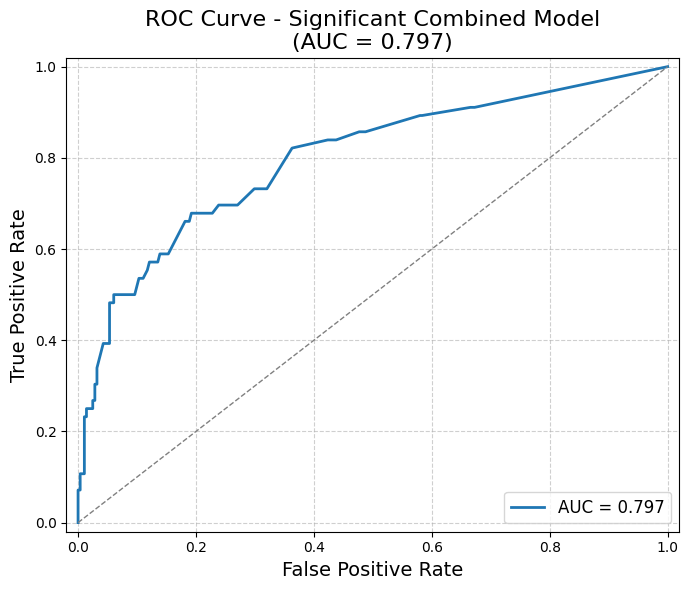

In [40]:
# Prepare train and test data for combined model
X_train_significant = df_train[significant_categories_]
X_test_significant = df_test[significant_categories_]
y_train_significant = df_train['AD']
y_test_significant = df_test['AD']

# Check correlations
corr_matrix = X_train_significant.corr()
print("\n🔎 Correlation matrix between significant categories:\n", corr_matrix)

# Remove highly correlated composites (>0.90)
features_to_drop = drop_highly_correlated_features(X_train_significant, threshold=0.90)

# Drop them
X_train_final = X_train_significant.drop(columns=features_to_drop)
X_test_final = X_test_significant.drop(columns=features_to_drop)
print(f"\nDropped features due to high correlation: {features_to_drop}")

# Run logistic regression on significant combined model
significant_combined_results = bootstrap_metrics(
    df_train=X_train_final,
    df_test=X_test_final,
    independent_vars=X_train_final.columns.tolist(),
    dep_var_train=y_train_significant,
    dep_var_test=y_test_significant,
    n_bootstrap=1000
)

# Display new combined model
print("\n============ Results for Significant Combined Model ============")
print("----- Odds Ratios (one-time fit) -----")
print(significant_combined_results["Odds Ratios (one-time fit)"])

print(f"\nBest Threshold Automatically Found: {significant_combined_results['Best Threshold']:.2f}")

print("\n----- Bootstrapped Metrics (1000 runs) -----")
for metric, (mean, ci) in significant_combined_results["Bootstrapped Metrics"].items():
    print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# Plot ROC Curve
plot_roc_curve(significant_combined_results["True Labels"], significant_combined_results["Predicted Probabilities"], title="ROC Curve - Significant Combined Model"
)

## Logisitc Regression on Significant Categories with "Good" Questions


Running logistic regression for category: Orientation_Time
Using class weighting automatically.
Best Threshold found automatically: 0.10


/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_16565/2145719264.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[f"{category}_COMPOSITE"] = df_train[questions].sum(axis=1, skipna=True)
/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_16565/2145719264.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f"{category}_COMPOSITE"] = df_test[questions].sum(axis=1, skipna=True)
/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_16565/2145719264.py:3: SettingWithCop


Running logistic regression for category: Orientation_Place
Using class weighting automatically.
Best Threshold found automatically: 0.13


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



Running logistic regression for category: Attention_Calculation
Using class weighting automatically.
Best Threshold found automatically: 0.39


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



Running logistic regression for category: Recall
Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



Running logistic regression for category: Language
Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



============ Results for Orientation_Time ============
----- Odds Ratios (one-time fit) -----
                            Odds Ratio  95% CI Lower  95% CI Upper  \
const                        99.405512     30.134791    327.908557   
Orientation_Time_COMPOSITE    0.248469      0.190197      0.324594   

                                 p-value  
const                       4.265233e-14  
Orientation_Time_COMPOSITE  1.760204e-24  

Best Threshold Automatically Found: 0.10

----- Bootstrapped Metrics (1000 runs) -----
AUC: Mean = 0.6507, 95% CI = [0.6432, 0.6575]
Balanced Accuracy: Mean = 0.6343, 95% CI = [0.6281, 0.6408]
Sensitivity: Mean = 0.4822, 95% CI = [0.4727, 0.4909]
Specificity: Mean = 0.7865, 95% CI = [0.7834, 0.7942]
Precision: Mean = 0.3096, 95% CI = [0.3023, 0.3176]
F1-score: Mean = 0.3770, 95% CI = [0.3688, 0.3857]

============ Results for Orientation_Place ============
----- Odds Ratios (one-time fit) -----
                             Odds Ratio  95% CI Lower  95% CI Up

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



============ Combined Results ============
----- Odds Ratios (one-time fit) -----
                                 Odds Ratio  95% CI Lower  95% CI Upper  \
const                             78.551502      0.000183  3.367681e+07   
Orientation_Time_COMPOSITE         0.373329      0.279206  4.991815e-01   
Orientation_Place_COMPOSITE        0.461418      0.297037  7.167694e-01   
Attention_Calculation_COMPOSITE    0.610246      0.458081  8.129567e-01   
Recall_COMPOSITE                   0.506925      0.416547  6.169124e-01   
Language_COMPOSITE                17.211223      0.025701  1.152589e+04   

                                      p-value  
const                            5.095731e-01  
Orientation_Time_COMPOSITE       2.982739e-11  
Orientation_Place_COMPOSITE      5.778748e-04  
Attention_Calculation_COMPOSITE  7.380719e-04  
Recall_COMPOSITE                 1.191687e-11  
Language_COMPOSITE               3.913702e-01  

Best Threshold Automatically Found: 0.22

----- Bootst

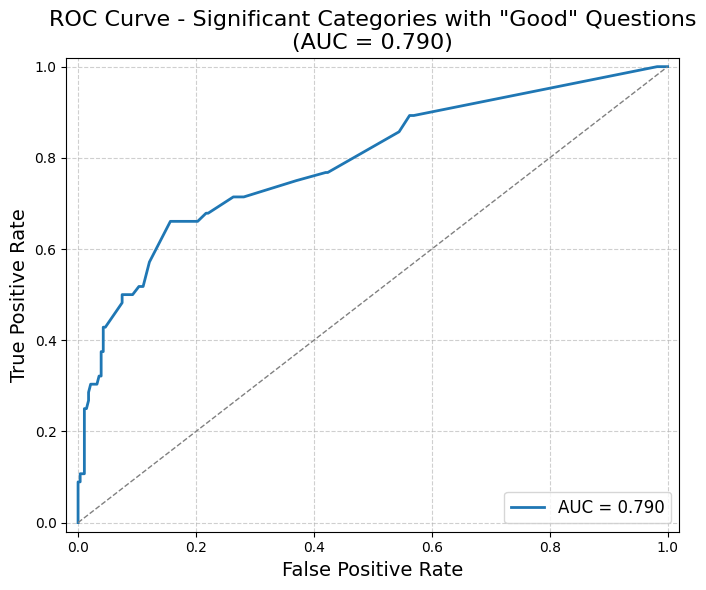

In [41]:
# Create composite scores for each category
for category, questions in updated_categories.items():
    df_train[f"{category}_COMPOSITE"] = df_train[questions].sum(axis=1, skipna=True)
    df_test[f"{category}_COMPOSITE"] = df_test[questions].sum(axis=1, skipna=True)

# Analyze each category
category_results = []

for category in updated_categories.keys():
    print(f"\nRunning logistic regression for category: {category}")

    try:
        # Define features and target
        X_train_category = df_train[[f"{category}_COMPOSITE"]]
        y_train_category = df_train['AD']
        X_test_category = df_test[[f"{category}_COMPOSITE"]]
        y_test_category = df_test['AD']

        # Run logistic regression with bootstrapping (auto threshold)
        results_category = bootstrap_metrics(
            df_train=X_train_category,
            df_test=X_test_category,
            independent_vars=[f"{category}_COMPOSITE"],
            dep_var_train=y_train_category,
            dep_var_test=y_test_category,
            n_bootstrap=1000
        )

        # Save results
        category_results.append({
            'Category': category,
            'Best Threshold': results_category["Best Threshold"],
            'Odds Ratios': results_category["Odds Ratios (one-time fit)"],
            'Bootstrapped Metrics': results_category["Bootstrapped Metrics"],
            'True Labels': results_category["True Labels"],
            'Predicted Probabilities': results_category["Predicted Probabilities"]
        })

    except Exception as e:
        print(f"Error running logistic regression for category {category}: {e}")
        continue

# Display results for each category
for result in category_results:
    print(f"\n============ Results for {result['Category']} ============")
    print("----- Odds Ratios (one-time fit) -----")
    print(result['Odds Ratios'])
    print(f"\nBest Threshold Automatically Found: {result['Best Threshold']:.2f}")
    print("\n----- Bootstrapped Metrics (1000 runs) -----")
    for metric, (mean, ci) in result['Bootstrapped Metrics'].items():
        print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# (Optional) Plot ROC Curve for each category
# for result in category_results:
#    plot_roc_curve(result["True Labels"], result["Predicted Probabilities"], title=f"ROC Curve - {result['Category']}")

# ======= Logistic Regression on Combined Model =======
combined_features = [f"{category}_COMPOSITE" for category in updated_categories.keys()]
X_train_combined = df_train[combined_features]
X_test_combined = df_test[combined_features]
y_train_combined = df_train['AD']
y_test_combined = df_test['AD']

# Run logistic regression on the combined model
updated_category_results = bootstrap_metrics(
    df_train=X_train_combined,
    df_test=X_test_combined,
    independent_vars=[f"{category}_COMPOSITE" for category in updated_categories.keys()],
    dep_var_train=y_train_combined,
    dep_var_test=y_test_combined,
    n_bootstrap=1000
)

# Display combined results
print("\n============ Combined Results ============")
print("----- Odds Ratios (one-time fit) -----")
print(updated_category_results["Odds Ratios (one-time fit)"])
print(f"\nBest Threshold Automatically Found: {updated_category_results['Best Threshold']:.2f}")
print("\n----- Bootstrapped Metrics (1000 runs) -----")
for metric, (mean, ci) in updated_category_results["Bootstrapped Metrics"].items():
    print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# (Optional) Plot ROC Curve for combined model
plot_roc_curve(updated_category_results["True Labels"], updated_category_results["Predicted Probabilities"], title='ROC Curve - Significant Categories with "Good" Questions')

## Logisitc Regression on Numerical ClinicalBERT Embeddings 


Running combined logistic regression for Numerical ClinicalBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.44


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



=== Combined Results for Numerical ClinicalBERT ===

----- Odds Ratios (one-time fit) -----
                                               Odds Ratio  95% CI Lower  \
const                                        1.102766e+04  9.261466e-16   
Orientation_Time_Numerical_Embedding_0       1.002674e-05  3.143712e-09   
Orientation_Place_Numerical_Embedding_0      2.874696e-08  8.081538e-15   
Attention_Calculation_Numerical_Embedding_0  9.036869e-06  1.397729e-09   
Recall_Numerical_Embedding_0                 6.115033e-04  1.388979e-05   
Language_Numerical_Embedding_0               3.533240e+08  4.491515e-31   

                                             95% CI Upper   p-value  
const                                        1.313066e+23  0.677886  
Orientation_Time_Numerical_Embedding_0       3.197988e-02  0.005169  
Orientation_Place_Numerical_Embedding_0      1.022563e-01  0.024055  
Attention_Calculation_Numerical_Embedding_0  5.842692e-02  0.009477  
Recall_Numerical_Embedding_0   

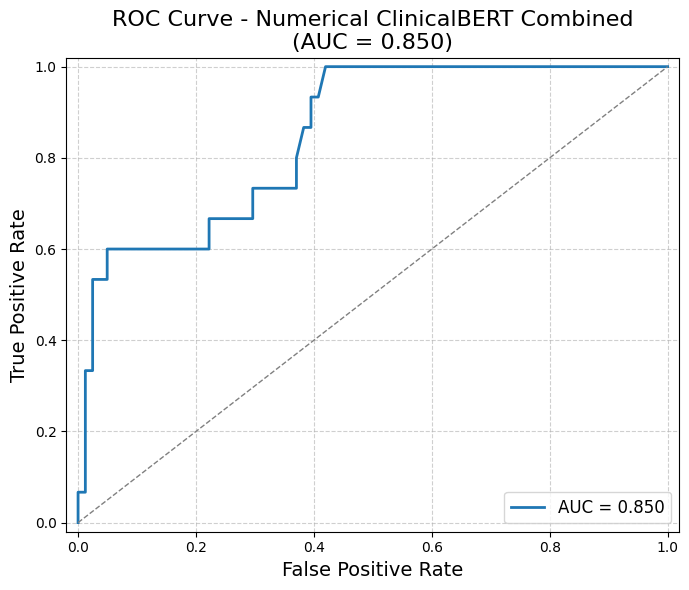

In [42]:
numerical_clinicalbert_combined_results = run_logistic_regression_pipeline(
    train_df=df_numerical_clinicalbert_train,
    test_df=df_numerical_clinicalbert_test,
    embedding_cols=[col for col in df_numerical_clinicalbert_train.columns if col.startswith("Numerical_Embedding_")],
    categories=updated_categories,
    model_name="Numerical ClinicalBERT",
    n_bootstrap=1000
)

## Logistic regression on ClinicalBERT embeddings.


Running combined logistic regression for ClinicalBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.12


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== Combined Results for ClinicalBERT ===

----- Odds Ratios (one-time fit) -----
                                      Odds Ratio   95% CI Lower  95% CI Upper  \
const                               1.580001e-23            NaN           NaN   
Orientation_Time_Embedding_0        5.048191e+06            NaN           NaN   
Orientation_Time_Embedding_1        1.143921e-01   0.000000e+00           inf   
Orientation_Time_Embedding_4        1.072640e+11            NaN           NaN   
Orientation_Time_Embedding_14       1.017019e-04   0.000000e+00           inf   
Orientation_Time_Embedding_15       2.026781e+01   0.000000e+00           inf   
Orientation_Time_Embedding_22       6.680928e+07            NaN           NaN   
Orientation_Time_Embedding_29       6.298712e-09            NaN           NaN   
Orientation_Time_Embedding_45       6.453970e-25   0.000000e+00           inf   
Orientation_Time_Embedding_53       1.057850e-18   0.000000e+00           inf   
Orientation_Time_Embedding

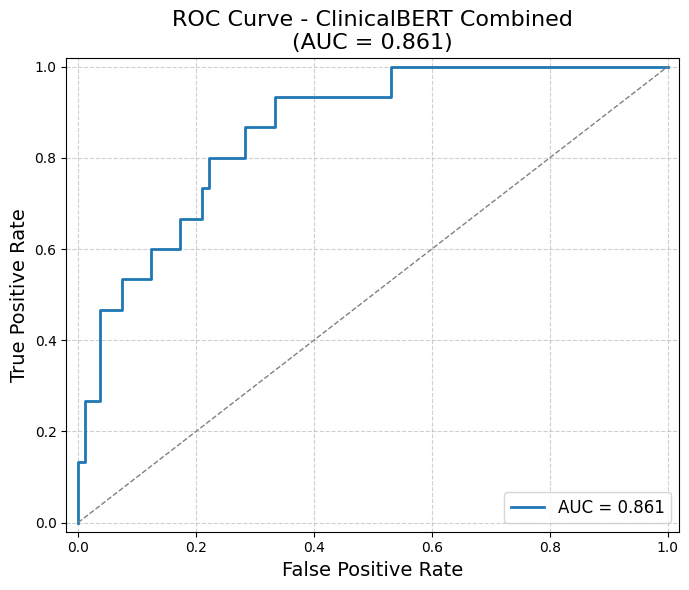

In [43]:
clinicalbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_clincalbert_train,
    test_df=df_clincalbert_test,
    embedding_cols=[col for col in df_clincalbert_train.columns if col.startswith('Embedding_')],
    categories=updated_categories,
    model_name="ClinicalBERT"
)


## Logistic Regression on Contextual ClinicalBERT embeddings


Running combined logistic regression for Contextual ClinicalBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.18


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== Combined Results for Contextual ClinicalBERT ===

----- Odds Ratios (one-time fit) -----
                                              Odds Ratio  95% CI Lower  \
const                                      4.120296e+111           NaN   
Orientation_Time_Context_Embedding_0       8.335159e-145           NaN   
Orientation_Time_Context_Embedding_1       4.856821e+277  0.000000e+00   
Orientation_Time_Context_Embedding_29       1.776313e-30  0.000000e+00   
Orientation_Time_Context_Embedding_35       3.968919e+26  0.000000e+00   
...                                                  ...           ...   
Orientation_Place_Context_Embedding_549    3.413853e-106  0.000000e+00   
Orientation_Place_Context_Embedding_604     1.474375e+74           NaN   
Orientation_Place_Context_Embedding_651     1.394702e+80  0.000000e+00   
Attention_Calculation_Context_Embedding_0   4.482343e-34  2.411153e-93   
Recall_Context_Embedding_0                  1.329942e-09  7.280318e-18   

                 

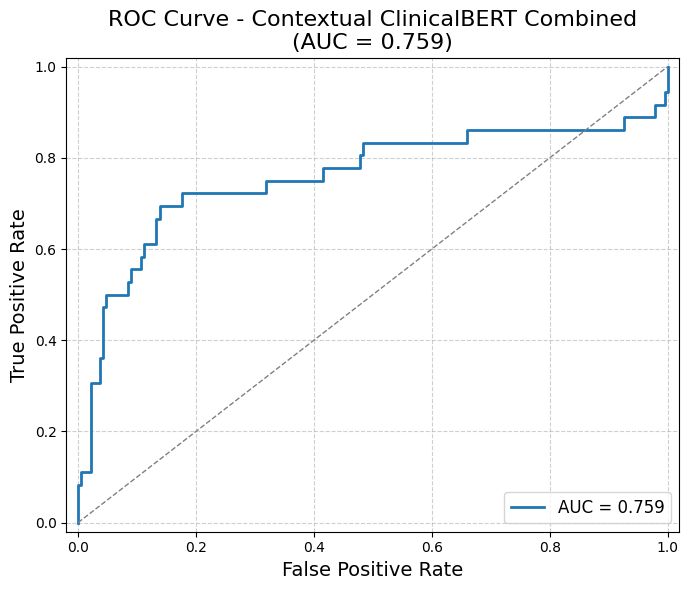

In [44]:
context_clinicalbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_context_clinicalbert_train,
    test_df=df_context_clinicalbert_test,
    embedding_cols=[col for col in df_context_clinicalbert_train.columns if col.startswith('Context_Embedding_')],
    categories=updated_categories,
    model_name="Contextual ClinicalBERT"
)


## Logisitc Regression on Numerical BioBERT Embeddings


Running combined logistic regression for Numerical BioBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.44


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



=== Combined Results for Numerical BioBERT ===

----- Odds Ratios (one-time fit) -----
                                               Odds Ratio  95% CI Lower  \
const                                        4.303316e+05  3.427091e-19   
Orientation_Time_Numerical_Embedding_0       1.008133e-05  3.172877e-09   
Orientation_Place_Numerical_Embedding_0      2.898338e-08  8.206183e-15   
Attention_Calculation_Numerical_Embedding_0  9.086511e-06  1.411236e-09   
Recall_Numerical_Embedding_0                 6.136413e-04  1.396326e-05   
Language_Numerical_Embedding_0               3.500589e+08  4.642022e-31   

                                             95% CI Upper   p-value  
const                                        5.403571e+29  0.646810  
Orientation_Time_Numerical_Embedding_0       3.203186e-02  0.005169  
Orientation_Place_Numerical_Embedding_0      1.023663e-01  0.024055  
Attention_Calculation_Numerical_Embedding_0  5.850524e-02  0.009477  
Recall_Numerical_Embedding_0        

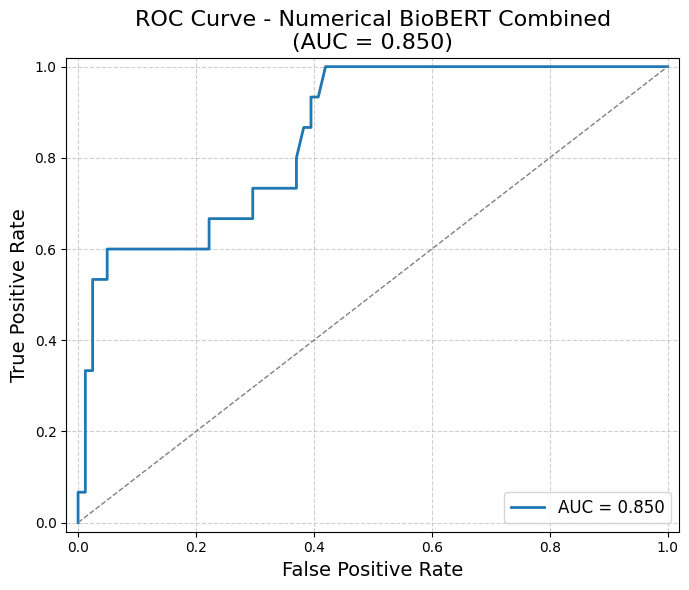

In [45]:
numerical_biobert_combined_results = run_logistic_regression_pipeline(
    train_df=df_numerical_biobert_train,
    test_df=df_numerical_biobert_test,
    embedding_cols=[col for col in df_numerical_biobert_train.columns if col.startswith("Numerical_Embedding_")],
    categories=updated_categories,
    model_name="Numerical BioBERT",
    n_bootstrap=1000
)

## Logistic Regression on BioBert embeddings


Running combined logistic regression for BioBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.52


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



=== Combined Results for BioBERT ===

----- Odds Ratios (one-time fit) -----
                                     Odds Ratio  95% CI Lower   95% CI Upper  \
const                              1.467630e+33  2.069016e-09   1.041045e+75   
Orientation_Time_Embedding_0       4.125918e-05  3.199683e-49   5.320276e+39   
Orientation_Time_Embedding_354     2.079310e+96  1.185449e-09  3.647167e+201   
Orientation_Place_Embedding_0      2.390114e-45  1.254543e-89   4.553568e-01   
Attention_Calculation_Embedding_0  1.299501e-29  1.146083e-49   1.473457e-09   
Recall_Embedding_0                 1.707759e-47  1.158919e-72   2.516518e-22   
Language_Embedding_12              5.676412e+21  2.908893e-97  1.107695e+140   

                                    p-value  
const                              0.120360  
Orientation_Time_Embedding_0       0.845537  
Orientation_Time_Embedding_354     0.072856  
Orientation_Place_Embedding_0      0.048258  
Attention_Calculation_Embedding_0  0.004756  
Recal

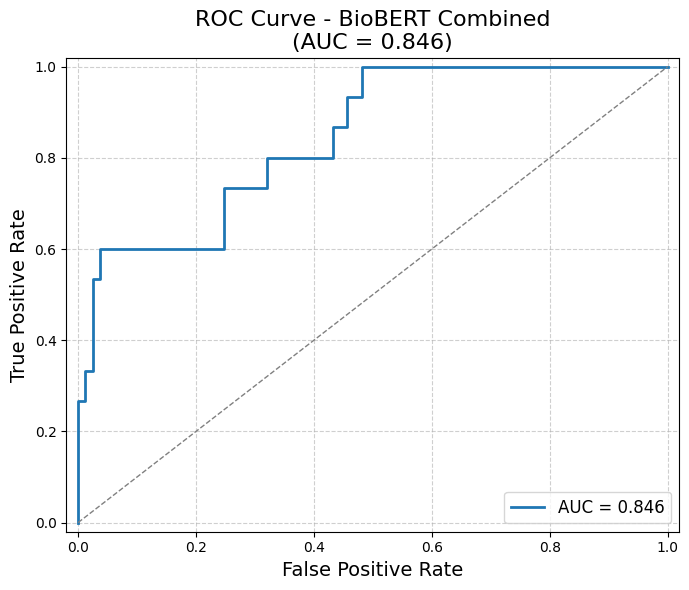

In [46]:
biobert_combined_result = run_logistic_regression_pipeline(
    train_df=df_biobert_train,
    test_df=df_biobert_test,
    embedding_cols=[col for col in df_biobert_train.columns if col.startswith('Embedding_')],
    categories=updated_categories,
    model_name="BioBERT"
)

## Logistic Regression on Contextual BioBert embeddings

In [47]:
# context_biobert_combined_result = run_logistic_regression_pipeline(
#     train_df=df_context_biobert_train,
#     test_df=df_context_biobert_test,
#     embedding_cols=[col for col in df_context_biobert_train.columns if col.startswith('Context_Embedding_')],
#     categories=updated_categories,
#     model_name="Contextual BioBERT"
# )

## Logisitic Regression on Numerical MedBERT Embeddings


Running combined logistic regression for Numerical MedBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.44


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



=== Combined Results for Numerical MedBERT ===

----- Odds Ratios (one-time fit) -----
                                               Odds Ratio  95% CI Lower  \
const                                        2.849132e+07  4.050013e-23   
Orientation_Time_Numerical_Embedding_0       5.992072e-04  3.303402e-06   
Orientation_Place_Numerical_Embedding_0      1.375786e-05  8.231704e-10   
Attention_Calculation_Numerical_Embedding_0  5.603728e-04  1.959014e-06   
Recall_Numerical_Embedding_0                 8.480140e-03  7.392918e-04   
Language_Numerical_Embedding_0               3.239247e+05  2.734619e-20   

                                             95% CI Upper   p-value  
const                                        2.004327e+37  0.624470  
Orientation_Time_Numerical_Embedding_0       1.086908e-01  0.005169  
Orientation_Place_Numerical_Embedding_0      2.299388e-01  0.024055  
Attention_Calculation_Numerical_Embedding_0  1.602938e-01  0.009477  
Recall_Numerical_Embedding_0        

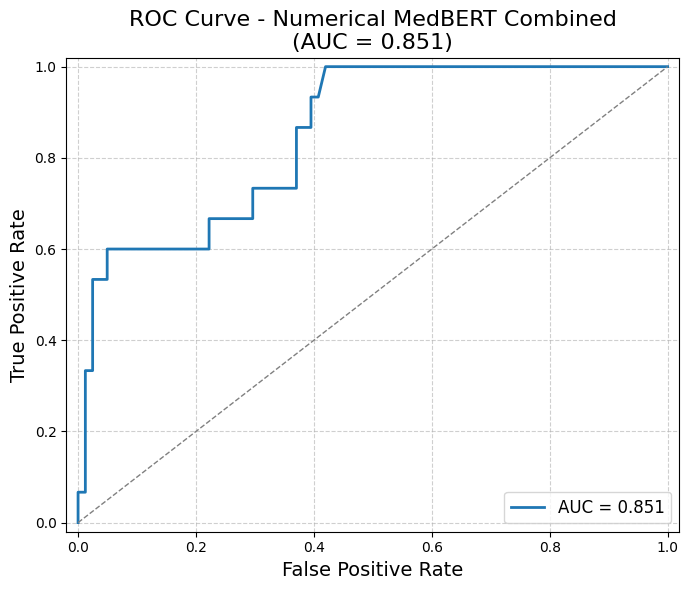

In [48]:
numerical_medbert_combined_results = run_logistic_regression_pipeline(
    train_df=df_numerical_medbert_train,
    test_df=df_numerical_medbert_test,
    embedding_cols=[col for col in df_numerical_medbert_train.columns if col.startswith("Numerical_Embedding_")],
    categories=updated_categories,
    model_name="Numerical MedBERT",
    n_bootstrap=1000
)

## Logistic Regression on MedBERT embeddings


Running combined logistic regression for MedBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge


=== Combined Results for MedBERT ===

----- Odds Ratios (one-time fit) -----
                              Odds Ratio  95% CI Lower  95% CI Upper   p-value
const                                0.0           0.0           inf  0.995376
Orientation_Time_Embedding_0         0.0           0.0           inf  0.995977
Orientation_Time_Embedding_1         inf           0.0           inf  0.999787
Orientation_Time_Embedding_2         inf           NaN           NaN       NaN
Orientation_Time_Embedding_3         inf           NaN           NaN       NaN
...                                  ...           ...           ...       ...
Language_Embedding_2                 inf           0.0           inf  0.918237
Language_Embedding_7                 inf           0.0           inf  0.828025
Language_Embedding_12                inf           0.0           inf  0.592406
Language_Embedding_17                inf           0.0           inf  0.897154
Language_Embedding_427               inf           0.

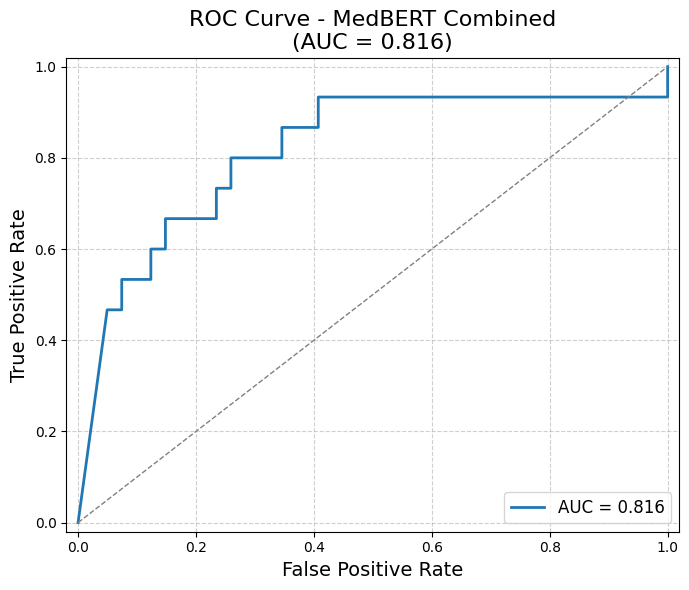

In [49]:
medbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_medbert_train,
    test_df=df_medbert_test,
    embedding_cols=[col for col in df_medbert_train.columns if col.startswith('Embedding_')],
    categories=updated_categories,
    model_name="MedBERT"
)

## Logisitc Regression on Contextual MedBERT embeddings


Running combined logistic regression for Contextual MedBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.32


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== Combined Results for Contextual MedBERT ===

----- Odds Ratios (one-time fit) -----
                                         Odds Ratio  95% CI Lower  \
const                                  3.057225e-01           0.0   
Orientation_Time_Context_Embedding_0   2.537520e+26           0.0   
Orientation_Time_Context_Embedding_5   1.326209e+35           NaN   
Orientation_Time_Context_Embedding_6   8.458603e+20           NaN   
Orientation_Time_Context_Embedding_13  2.964374e-13           NaN   
...                                             ...           ...   
Recall_Context_Embedding_7             1.885280e+10           0.0   
Recall_Context_Embedding_31            6.659966e-11           0.0   
Recall_Context_Embedding_290           3.734041e-13           0.0   
Recall_Context_Embedding_304           1.221359e+26           NaN   
Recall_Context_Embedding_394           1.191617e+10           0.0   

                                       95% CI Upper   p-value  
const             

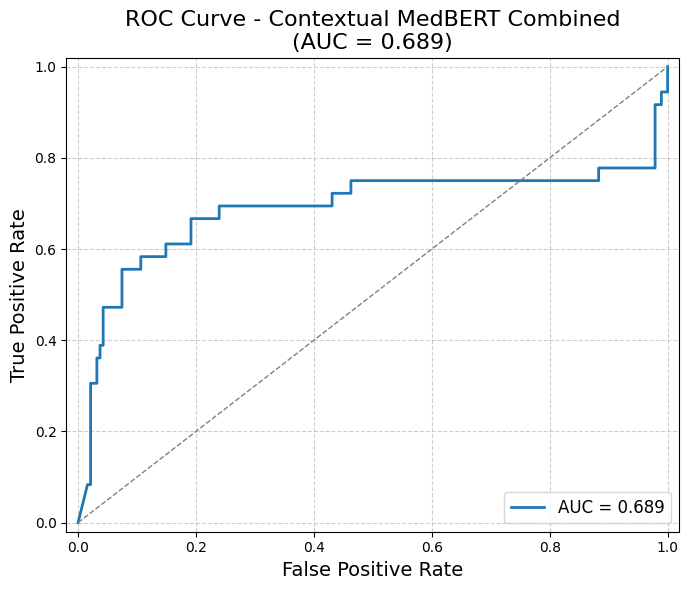

In [50]:
context_medbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_context_medbert_train,
    test_df=df_context_medbert_test,
    embedding_cols=[col for col in df_context_medbert_train.columns if col.startswith('Context_Embedding_')],
    categories=updated_categories,
    model_name="Contextual MedBERT"
)

## Display the results from each model

In [51]:
import pandas as pd

# Collect results from each combined model
combined_model_results = [mmsescore_results,
                         combined_category_results,
                         significant_combined_results,
                         updated_category_results,
                         clinicalbert_combined_result,
                         context_clinicalbert_combined_result,
                         biobert_combined_result,
                         medbert_combined_result,
                         context_medbert_combined_result]
# Define model names
combined_model_names = ['MMSE Score',
                        'MMSE Categories',
                        'Significant MMSE Categories',
                        'Updated Significant MMSE Categories', 
                        'ClinicalBERT',
                        'Contextual ClinicalBERT',
                        'BioBERT',
                        'MedBERT',
                        'Contextual MedBERT']

# Initialize list to store summary rows
summary_rows = []

for result, name in zip(combined_model_results, combined_model_names):
    row = {'Model': name}

    # # Extract odds ratios
    # odds_ratios = result['Odds Ratios (one-time fit)']
    # row['Odds Ratios'] = odds_ratios.to_dict()

    # Extract best threshold
    row['Best Threshold'] = result.get('Best Threshold', None)

    # Extract bootstrapped metrics
    for metric_name, (mean, ci) in result['Bootstrapped Metrics'].items():
        row[f'{metric_name}'] = round(mean, 4)
        # row[f'{metric_name} 95% CI Lower'] = round(ci[0], 4)
        # row[f'{metric_name} 95% CI Upper'] = round(ci[1], 4)

    summary_rows.append(row)

# Create a summary DataFrame
summary_df = pd.DataFrame(summary_rows)

# Display the summary DataFrame
from IPython.display import display
print("=== Summary of Combined Model Results ===")
display(summary_df)

# Save the summary DataFrame to a CSV file
summary_df.to_csv("data/Combined_Model_Metrics_Summary.csv", index=False)


=== Summary of Combined Model Results ===


,Model,Best Threshold,AUC,Balanced Accuracy,Sensitivity,Specificity,Precision,F1-score
0,MMSE Score,0.12,0.7946,0.7253,0.6783,0.7723,0.3716,0.4802
1,MMSE Categories,0.18,0.7998,0.7466,0.6783,0.8150,0.4213,0.5198
2,Significant MMSE Categories,0.16,0.7975,0.7431,0.6783,0.8079,0.4122,0.5127
3,Updated Significant MMSE Categories,0.22,0.7907,0.7519,0.6604,0.8435,0.4558,0.5394
4,ClinicalBERT,0.12,0.8606,0.7464,0.6655,0.8274,0.4122,0.5089
5,Contextual ClinicalBERT,0.18,0.7590,0.7725,0.6939,0.8512,0.4701,0.5604
6,BioBERT,0.52,0.8461,0.7813,0.5997,0.9629,0.7465,0.6646
7,MedBERT,0.10,0.8150,0.7291,0.5324,0.9258,0.5664,0.5485
8,Contextual MedBERT,0.32,0.6890,0.7405,0.5555,0.9255,0.5865,0.5705


In [52]:
# Extract and display Odds Ratios for combined_category_results
import pandas as pd

# Assuming combined_category_results is already computed
odds_ratios = updated_category_results["Odds Ratios (one-time fit)"]

# Convert to DataFrame if not already
if isinstance(odds_ratios, dict):
    odds_ratios_df = pd.DataFrame.from_dict(odds_ratios, orient='index', columns=['Odds Ratio'])
else:
    odds_ratios_df = odds_ratios

# Display the table
print("=== Odds Ratios for Combined Category Results ===")
print(odds_ratios_df)

# Save to CSV (optional)
# odds_ratios_df.to_csv("data/Odds_Ratios_Combined_Category_Results.csv", index=True)

=== Odds Ratios for Combined Category Results ===
                                 Odds Ratio  95% CI Lower  95% CI Upper  \
const                             78.551502      0.000183  3.367681e+07   
Orientation_Time_COMPOSITE         0.373329      0.279206  4.991815e-01   
Orientation_Place_COMPOSITE        0.461418      0.297037  7.167694e-01   
Attention_Calculation_COMPOSITE    0.610246      0.458081  8.129567e-01   
Recall_COMPOSITE                   0.506925      0.416547  6.169124e-01   
Language_COMPOSITE                17.211223      0.025701  1.152589e+04   

                                      p-value  
const                            5.095731e-01  
Orientation_Time_COMPOSITE       2.982739e-11  
Orientation_Place_COMPOSITE      5.778748e-04  
Attention_Calculation_COMPOSITE  7.380719e-04  
Recall_COMPOSITE                 1.191687e-11  
Language_COMPOSITE               3.913702e-01  


## ROC Curves for the different models

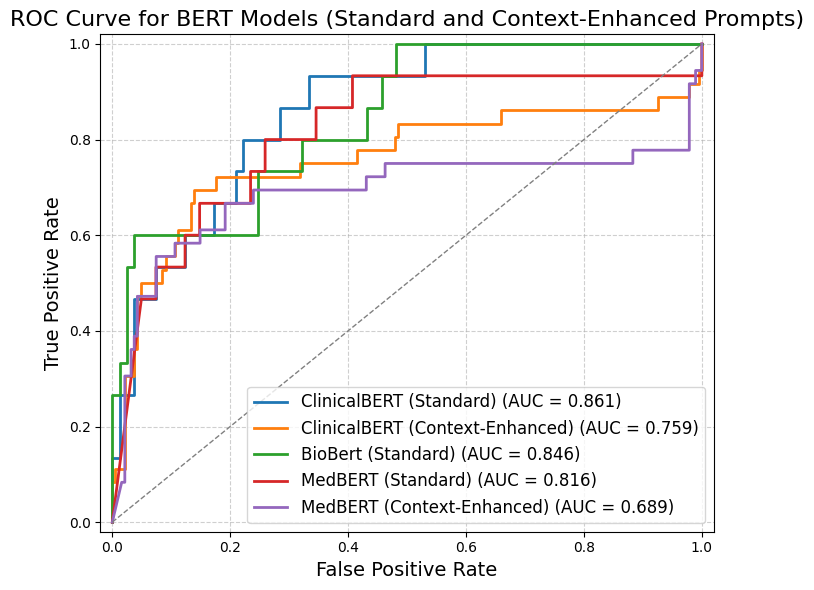

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC Curves for specified models (Styled)
def plot_roc_curves(model_results, title='ROC Curve'):
    plt.figure(figsize=(7, 6))

    for model_name, (y_true, y_scores) in model_results.items():
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

    # Random Chance line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

    # Plot settings
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f"{title}", fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Function to plot both ClinicalBERT models together
def plot_bert_combined_roc(clinicalbert_combined_result, context_clinicalbert_combined_result, biobert_combined_result, medbert_combined_result, context_medbert_combined_result):
    model_results = {
        'ClinicalBERT (Standard)': (clinicalbert_combined_result["True Labels"], clinicalbert_combined_result["Predicted Probabilities"]),
        'ClinicalBERT (Context-Enhanced)': (context_clinicalbert_combined_result["True Labels"], context_clinicalbert_combined_result["Predicted Probabilities"]),
        'BioBert (Standard)': (biobert_combined_result["True Labels"], biobert_combined_result["Predicted Probabilities"]),
        'MedBERT (Standard)': (medbert_combined_result["True Labels"], medbert_combined_result["Predicted Probabilities"]),
        'MedBERT (Context-Enhanced)': (context_medbert_combined_result["True Labels"], context_medbert_combined_result["Predicted Probabilities"])
    }
    plot_roc_curves(model_results, title='ROC Curve for BERT Models (Standard and Context-Enhanced Prompts)')

plot_bert_combined_roc(clinicalbert_combined_result, context_clinicalbert_combined_result, biobert_combined_result, medbert_combined_result, context_medbert_combined_result)

## Confusion Matrix

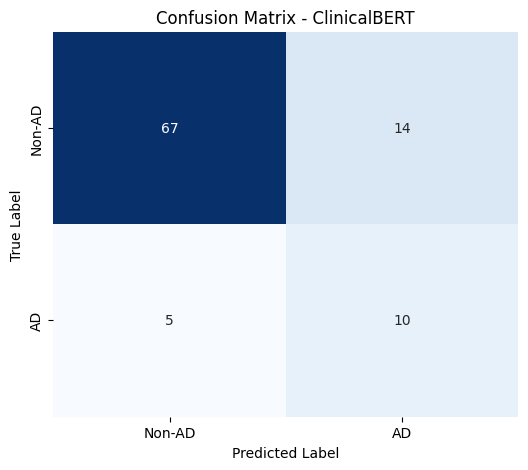

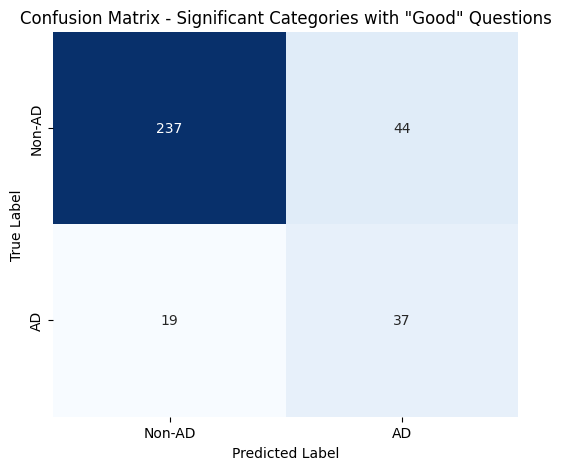

In [54]:
# Generate Confusion Matrix for ClincalBERT
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-AD', 'AD'], yticklabels=['Non-AD', 'AD'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Generate confusion matrix for ClinicalBERT
clinicalbert_y_true = clinicalbert_combined_result["True Labels"]
clinicalbert_y_pred = (clinicalbert_combined_result["Predicted Probabilities"] > clinicalbert_combined_result['Best Threshold']).astype(int)
plot_confusion_matrix(clinicalbert_y_true, clinicalbert_y_pred, title='Confusion Matrix - ClinicalBERT')

# Generate confusion matrix for Significant Combined Model with Good Questions
significant_y_true = updated_category_results["True Labels"]
significant_y_pred = (updated_category_results["Predicted Probabilities"] > updated_category_results['Best Threshold']).astype(int)
plot_confusion_matrix(significant_y_true, significant_y_pred, title='Confusion Matrix - Significant Categories with "Good" Questions')